# Satellite Earth’s outgoing shortwave radiation budget intercomparison for climate monitoring

Production date: 29-06-2023

Produced by: CNR-ISMAR, Andrea Storto, Vincenzo de Toma

## 🌍 Use case: Assessment of different datasets of OSR (outgoing shortwave radiation).

## ❓ Quality assessment question(s)
* **What are the differences in outgoing shortwave radiation among the different products of the ERB dataset?**


**‘Context’ (no title/heading)** - The OSR products allow quantifying the outgoing solar radiation for several climate applications. Their temporal coverage varies between the products, and the consistency is sufficient except at high latitudes, whose differences produce an offset between the products. 

## 📢 Quality assessment statement

```{admonition} Key outcomes of this assessment
:class: note
* The OSR products capture the spatial and temporal variability of the outgoing solar radiation (at the top of the atmosphere) for use in climate analyses, climate model evaluations, and radiative forcing studies.
* The ERB OSR products have different temporal coverage and spatial resolution, namely their combined use is not straightforward and it is recommended for advanced users only, or within specific periods.
* The consistency between the products concerning spatially averaged values is not high, showing systematic offsets between the products.
* Climatological maps and zonally averaged values indicate that the products are sufficiently consistent in most areas, except at high latitudes where differences are significant.
```

The estimation of outgoing shortwave radiation (OSR) at the top of the atmosphere is critical for quantifying the Earth's radiation budget (ERB) and understanding the planet's albedo and energy balance. However, assessing OSR variability using remote sensing data and satellite missions is challenging due to factors such as cloud cover variability, aerosol interactions, and calibration discrepancies among different satellite instruments ([[1]](https://doi.org/10.1175/1520-0477(1996)077%3C0853:CATERE%3E2.0.CO;2); [[2]](https://doi.org/10.1007/s10712-012-9175-1)).

```{figure} attachment:f5249d7b-e28d-4aa2-a02e-52d273fd7c8b.png
Zonally averaged outgoing shortwave radiation at the top of the atmosphere
```
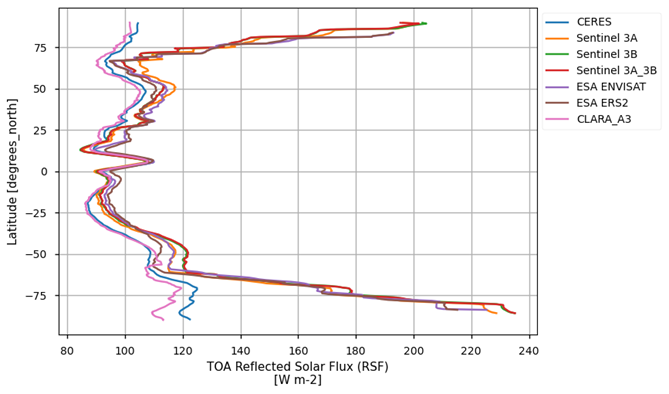

## 📋 Methodology

In this notebook we inter-compare the following catalogue entries from the Climate and Atmosphere Data Store (CADS) by Copernicus:
1. CERES Energy Balanced and Filled (EBAF) TOA Monthly means data in netCDF Edition4.1. NASA Langley Atmospheric Science Data Center DAAC (NASA CERES EBAF)
2. Earth's radiation budget from 1979 to present derived from satellite observations. CCI ICDR product version 3.1. Copernicus Climate Change Service Climate Data Store (C3S CCI).
3. ESA Cloud Climate Change Initiative (ESA Cloud_cci) data: Cloud_cci ATSR2-AATSR L3C/L3U CLD_PRODUCTS v3.0 (ESA Cloud CCI).

The analysis and results are organised in the following steps, which are detailed in the sections below:

**1. [Choose the data to use and setup code](choose-the-data-to-use-and-setup-code):**

**2. [Download and Transform](download-and-transform):**

**3. [Plot Spatial weighted time series, Time weighted means, Spatial weighted Zonal means](plot-spatial-weighted-time-series-time-weighted-means-spatial-weighted-zonal-means):**

 * Plot Spatial weighted time series
 * Time weighted means
 * Spatial weighted Zonal means
 

## 📈 Analysis and results

(choose-the-data-to-use-and-setup-code)=
### 1. Choose the data to use and setup code

In this section, we import the required packages and set up the dataset names for further use in the following sections. Processing functions are also defined.


In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

# Variable to analyse
variable = "shortwave"
assert variable in ("longwave", "shortwave")

# Region for timeseries
region_slices = {
    "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
    "northern hemisphere": {"lat_slice": slice(0, 90), "lon_slice": slice(0, 360)},
    "southern hemisphere": {"lat_slice": slice(-90, 0), "lon_slice": slice(0, 360)},
}

collection_id = "satellite-earth-radiation-budget"
chunks = {"year": 1}
varnames = (
    {"olr", "toa_lw_all_mon", "LW_flux"}
    if variable == "longwave"
    else {"rsf", "toa_sw_all_mon", "SW_flux"}
)

request_dict = {
    "CERES": {
        "start": "2000-03",
        "stop": "2024-02",
        "product_family": "ceres_ebaf",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "format": "zip",
        "origin": "nasa",
        "variable": f"outgoing_{variable}_radiation",
    },
    "Sentinel 3A": {
        "start": "2017-01",
        "stop": "2022-06",
        "format": "zip",
        "origin": "c3s",
        "sensor_on_satellite": "slstr_on_sentinel_3a",
        "variable": "all_variables",
        "product_family": "cci",
        "time_aggregation": "monthly_mean",
        "climate_data_record_type": "interim_climate_data_record",
    },
    "Sentinel 3B": {
        "start": "2018-10",
        "stop": "2022-06",
        "format": "zip",
        "origin": "c3s",
        "sensor_on_satellite": "slstr_on_sentinel_3b",
        "variable": "all_variables",
        "product_family": "cci",
        "time_aggregation": "monthly_mean",
        "climate_data_record_type": "interim_climate_data_record",
    },
    "Sentinel 3A_3B": {
        "start": "2018-10",
        "stop": "2022-06",
        "format": "zip",
        "origin": "c3s",
        "sensor_on_satellite": "slstr_on_sentinel_3a_3b",
        "variable": "all_variables",
        "product_family": "cci",
        "time_aggregation": "monthly_mean",
        "climate_data_record_type": "interim_climate_data_record",
    },
    "ESA ENVISAT": {
        "start": "2002-05",
        "stop": "2012-04",
        "format": "zip",
        "origin": "esa",
        "product_family": "cci",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "sensor_on_satellite": "aatsr",
        "variable": "all_variables",
    },
    "ESA ERS2": {
        "start": "1995-06",
        "stop": "2002-12",
        "format": "zip",
        "origin": "esa",
        "product_family": "cci",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "sensor_on_satellite": "atsr2",
        "variable": "all_variables",
    },
    "HIRS": {
        "start": "1979-01",
        "stop": "2024-04",
        "format": "zip",
        "origin": "noaa_ncei",
        "product_family": "hirs",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "version": "2_7_reprocessed",
        "variable": f"outgoing_{variable}_radiation",
    },
    "CLARA_A3": {
        "start": "1979-01",
        "stop": "2020-12",
        "product_family": "clara_a3",
        "origin": "eumetsat",
        "variable": f"outgoing_{variable}_radiation",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
    },
}

def preprocess_time(ds):
    if "time" in ds and "units" in ds["time"].attrs:
        # Could not decode
        ds = ds.squeeze("time", drop=True)
    if "time" not in ds:
        time = pd.to_datetime(ds.attrs["time_coverage_start"])
        ds = ds.assign_coords(time=time)
    return ds


def spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(ds)

xarray_kwargs = {
    "drop_variables": ["time_bounds", "record_status"],
    "preprocess": preprocess_time,
}

(download-and-transform)=
### 2. Download and Transform

The code below will download the products.

In [2]:
da_maps = {}
da_timeseries = {}
for product, request in request_dict.items():
    if product == "HIRS" and variable == "shortwave":
        print(f"{product=} skip")
        continue
    print(f"{product=}")

    start = request.pop("start")
    stop = request.pop("stop")
    requests = download.update_request_date(
        request, start=start, stop=stop, stringify_dates=True
    )

    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=diagnostics.time_weighted_mean,
        chunks=chunks,
        transform_chunks=False,
        **xarray_kwargs,
    )
    (varname,) = set(ds.data_vars) & varnames
    da = ds[varname]
    da.attrs.update({"start": start, "stop": stop})
    da_maps[product] = da

    dataarrays = []
    for region, slices in region_slices.items():
        ds = download.download_and_transform(
            collection_id,
            requests,
            transform_func=spatial_weighted_mean,
            transform_func_kwargs=slices,
            chunks=chunks,
            **xarray_kwargs,
        )
        dataarrays.append(ds[varname].expand_dims(region=[region]))
    da = xr.concat(dataarrays, "region")
    da_timeseries[product] = da

product='CERES'


100%|██████████| 25/25 [00:01<00:00, 22.07it/s]


product='Sentinel 3A'


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]


product='Sentinel 3B'


100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


product='Sentinel 3A_3B'


100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


product='ESA ENVISAT'


100%|██████████| 11/11 [00:00<00:00, 15.00it/s]


product='ESA ERS2'


100%|██████████| 8/8 [00:00<00:00, 15.69it/s]


product='HIRS' skip
product='CLARA_A3'


100%|██████████| 42/42 [00:02<00:00, 18.00it/s]


(plot-spatial-weighted-time-series-time-weighted-means-spatial-weighted-zonal-means)=
### 3. Plot Spatial weighted time series, Time weighted means, Spatial weighted Zonal means

#### Plot Spatial weighted time series
Below, we calculate and plot spatially weighted means for the different radiation budget products. Please note that masks of available data may differ across the products.

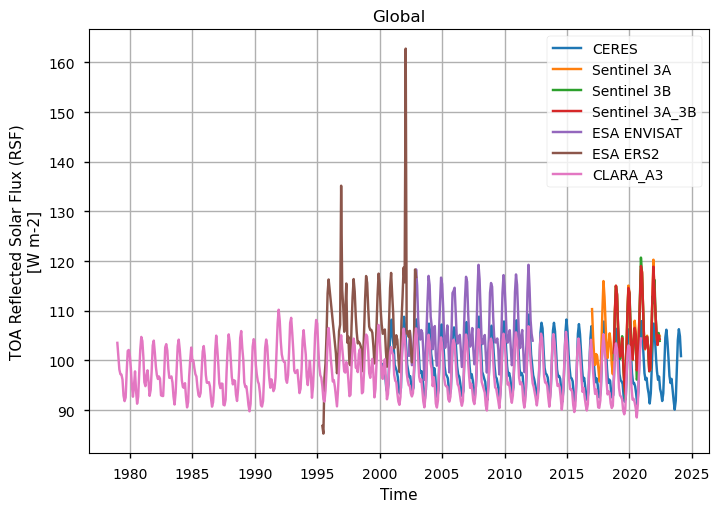

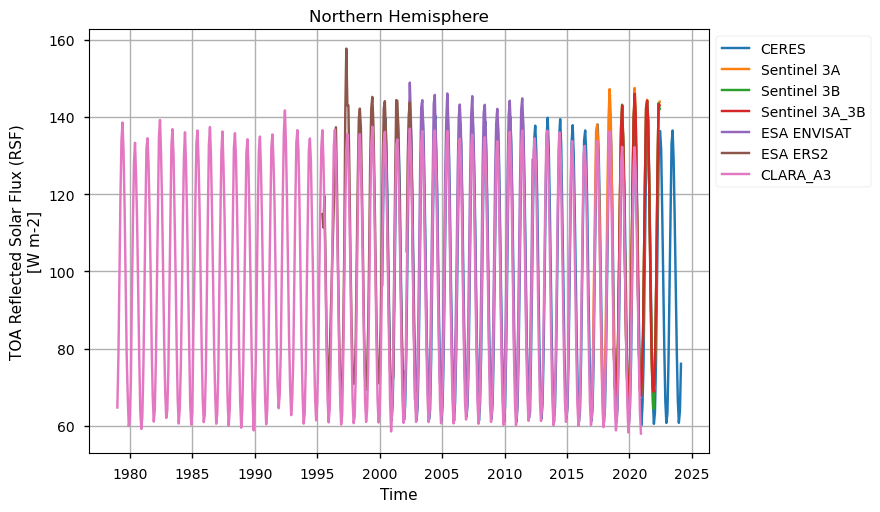

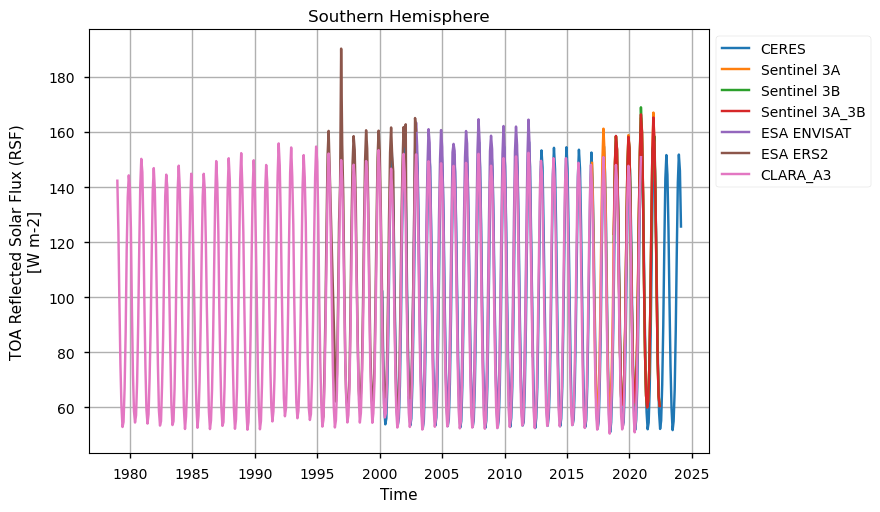

In [3]:
for region in region_slices:
    for product, da in da_timeseries.items():
        da.sel(region=region).plot(label=product)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(region.title())
    plt.grid()
    plt.show()

Timeseries show different temporal sampling for the products, with CLARA covering the longest temporal period.

#### Plot Time weighted means
Below, we calculate and plot time-weighted means for the different radiation budget products. Please note that periods differ across the products as shown in the previous section.

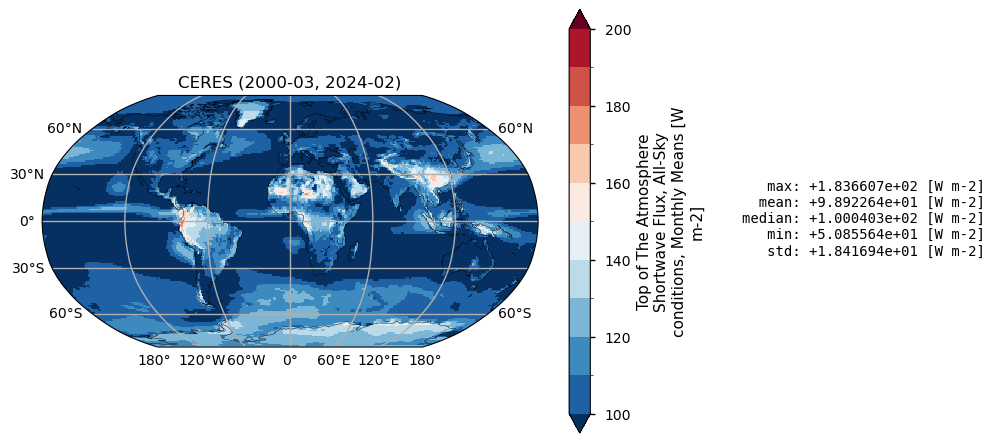

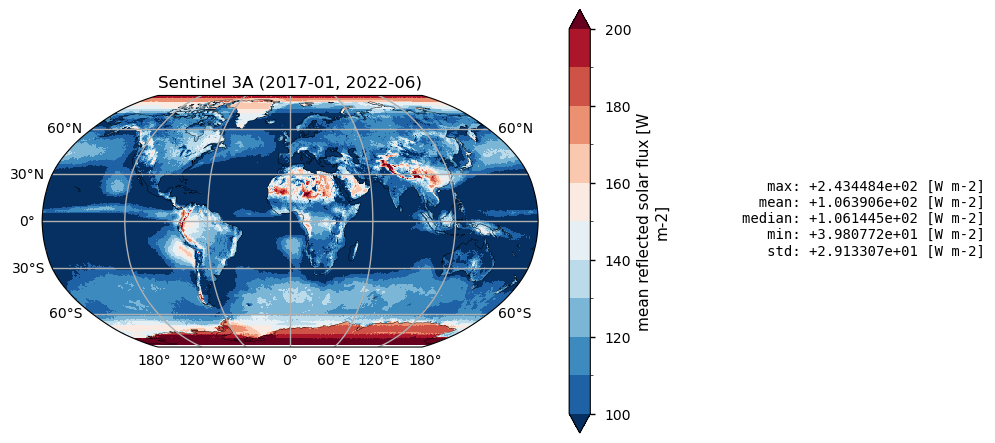

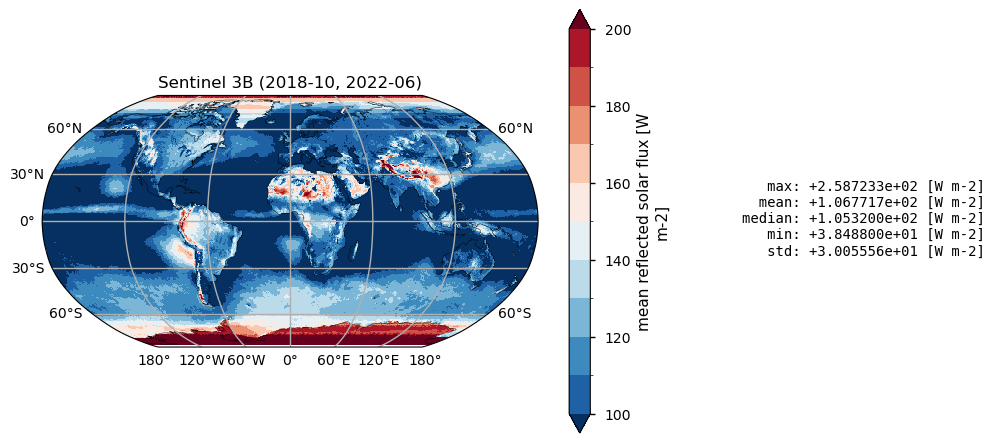

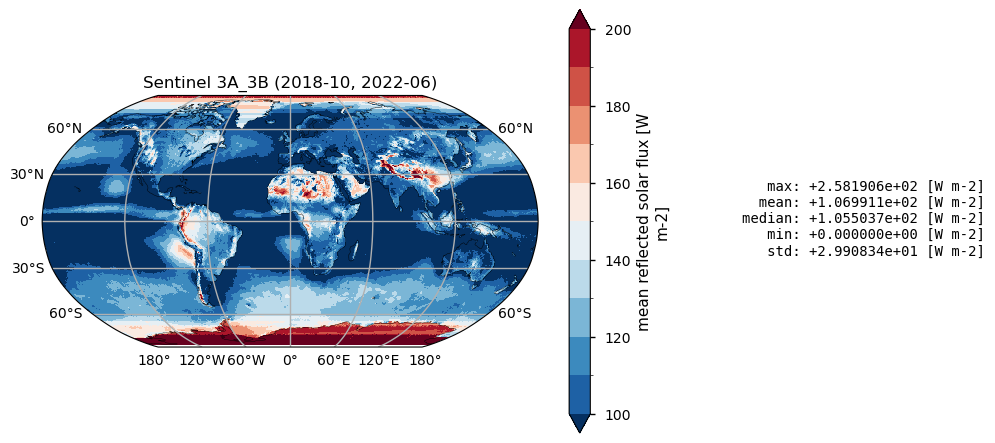

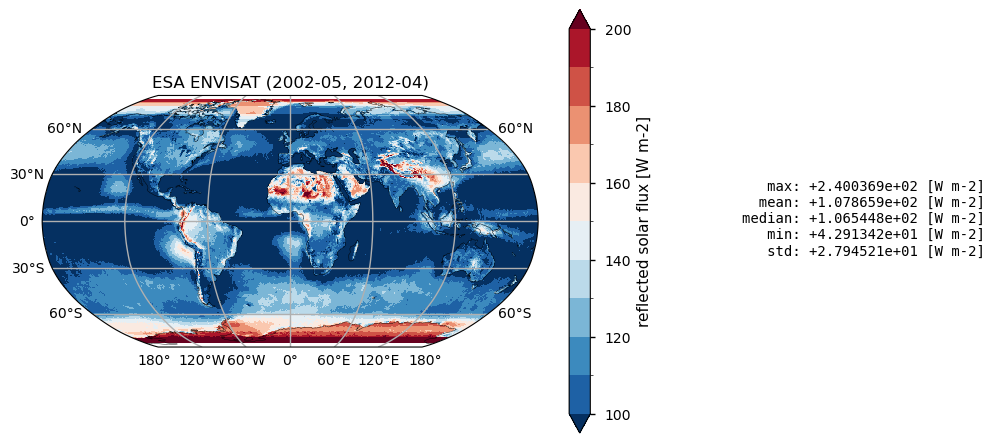

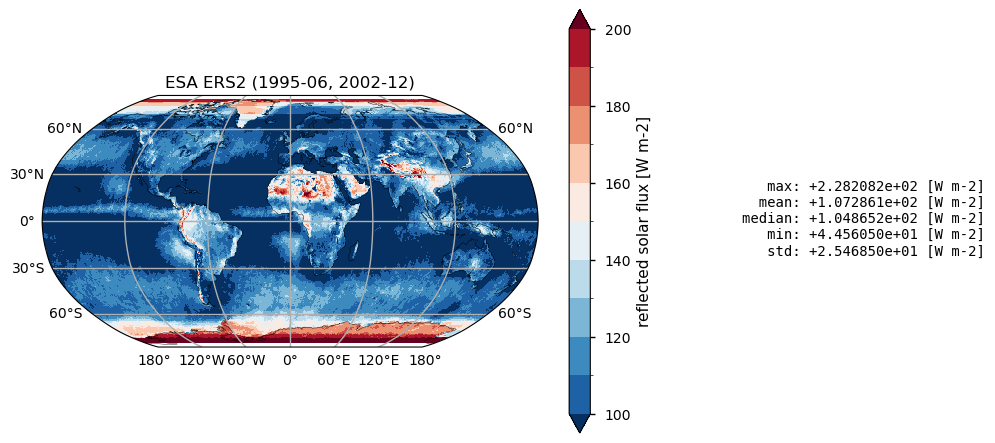

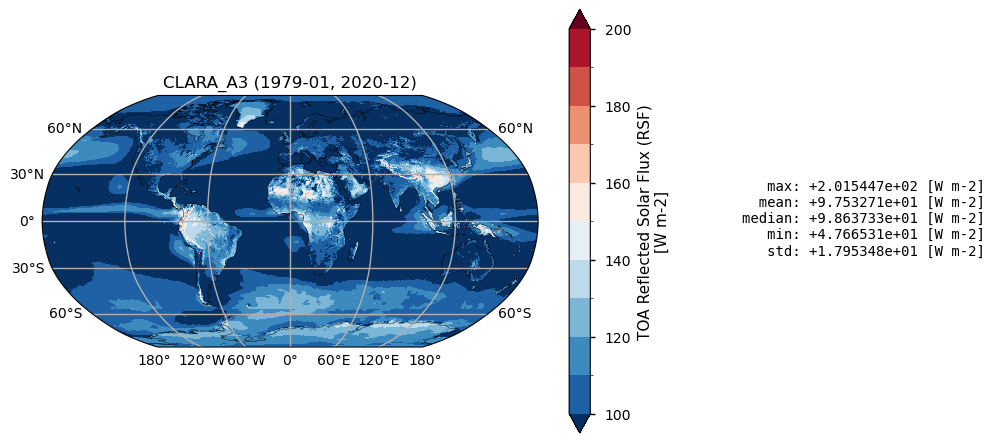

In [4]:
for product, da in da_maps.items():
    plot.projected_map(
        da,
        projection=ccrs.Robinson(),
        levels=range(150, 315, 15) if variable == "longwave" else range(100, 210, 10),
        extend="both",
        cmap="RdBu_r",
    )
    plt.title(f"{product} ({da.attrs['start']}, {da.attrs['stop']})")
    plt.show()

Time mean spatial maps show consisten spatial features across the products, although with significant offsets and differences, expecially at high latitudes. Differences are also due to varying spatial resolution, and different temporal and spatial sampling across the products.

#### Plot Spatial weighted Zonal means
The code below will calculate and plot weighted zonal means for the radiation budget products. Please note that spatial and temporal sampling may differ across the products.

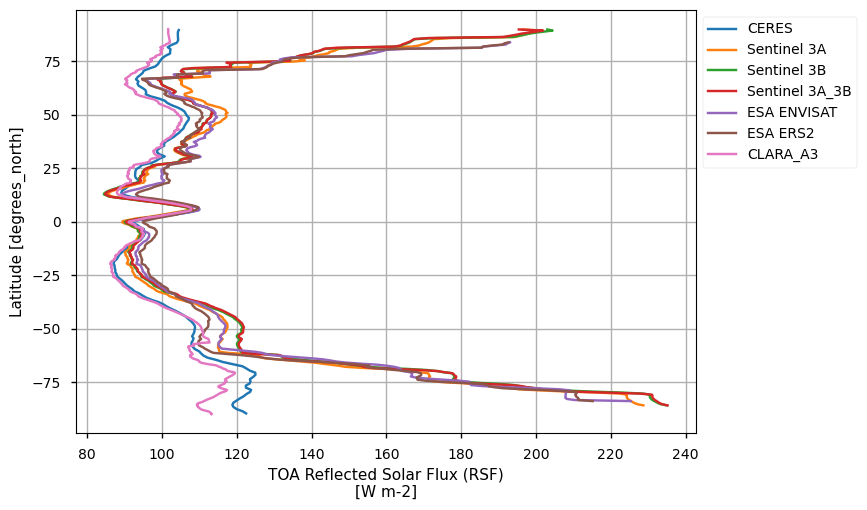

In [5]:
for product, da in da_maps.items():
    da = diagnostics.spatial_weighted_mean(da, dim="longitude")
    da.plot(y="latitude", label=product)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

The datasets show very good consistency only in the Tropics, while differ polarwards.

### Discussion and applications

Satellite-derived outgoing shortwave radiation (OSR) plays a critical role in climate investigations by providing essential data on the Earth's albedo and the amount of solar energy reflected back into space. OSR measurements, primarily obtained from instruments such as the Moderate Resolution Imaging Spectroradiometer (MODIS) and the Clouds and the Earth's Radiant Energy System (CERES), allow researchers to assess how changes in cloud cover, surface characteristics, and atmospheric conditions influence the Earth's energy balance ([[3]](https://doi.org/10.1038/ngeo1375); [[4]](https://doi.org/10.1073/pnas.1412190111)). By analyzing long-term OSR data, scientists can detect trends related to climate variability and change, including the impacts of anthropogenic activities on the planet's reflectivity ([[5]](https://doi.org/10.1038/nclimate2876)). For instance, variations in OSR can provide insights into the effects of land-use changes, such as deforestation and urbanization, which alter surface albedo and consequently affect local and global climate patterns ([[6]](https://doi.org/10.1175/JCLI-D-19-0212.1)). Furthermore, OSR data can help assess the accuracy of climate models, ultimately leading to better predictions of future climate scenarios and the potential impacts of climate change ([[7]](https://doi.org/10.1080/17538947.2023.2198262)). As such, OSR measurements are indispensable for understanding the intricate interactions between solar radiation, the Earth's surface, and the atmosphere, thereby contributing significantly to our knowledge of climate dynamics.

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1175/1520-0477(1996)077%3C0853:CATERE%3E2.0.CO;2) Wielicki, B. A., Barkstrom, B. R., Harrison, E. F., Lee III, R. B., Smith, G. L., & Cooper, J. E. (1996). Clouds and the Earth's Radiant Energy System (CERES): An Earth observing system experiment. Bulletin of the American Meteorological Society, 77(5), 853-868.

[[2]](https://doi.org/10.1007/s10712-012-9175-1) Loeb, N. G., Wielicki, B. A., Su, W., Loukachine, K., Sun, W., Wong, T., ... & Lin, B. (2012). Advances in understanding top-of-atmosphere radiation variability from satellite observations. Surveys in Geophysics, 33(3-4), 359-385

[[3]](https://doi.org/10.1038/ngeo1375) Loeb, N. G., J. M. Lyman, G. C. Johnson, R. P. Allan, D. R. Doelling, T. Wong, B. J. Soden, and G. L. Stephens, 2012: Observed changes in top-of-the-atmosphere radiation and upper-ocean heating consistent within uncertainty. Nat. Geosci., 5, 110–113, https://doi.org/10.1038/ngeo1375.

[[4]](https://doi.org/10.1073/pnas.1412190111) Donohoe, A., Armour, K. C., Pendergrass, A. G., & Battisti, D. S. (2014). Shortwave and longwave radiative contributions to global warming under increasing CO2. Proceedings of the National Academy of Sciences, 111(47), 16700-16705. https://doi.org/10.1073/pnas.1412190111

[[5]](https://doi.org/10.1038/nclimate2876) von Schuckmann, K., and Coauthors, 2016: An imperative to monitor Earth’s energy balance. Nat. Climate Change, 6, 138–144, https://doi.org/10.1038/nclimate2876.

[[6]](https://doi.org/10.1175/JCLI-D-19-0212.1) Schwarz, M., D. Folini, S. Yang, and M. Wild, 2019: The Annual Cycle of Fractional Atmospheric Shortwave Absorption in Observations and Models: Spatial Structure, Magnitude, and Timing. J. Climate, 32, 6729–6748, https://doi.org/10.1175/JCLI-D-19-0212.1.

[[7]](https://doi.org/10.1080/17538947.2023.2198262) Yang, S., Zhang, X., Guan, S., Zhao, W., Duan, Y., Yao, Y., … Jiang, B. (2023). A review and comparison of surface incident shortwave radiation from multiple data sources: satellite retrievals, reanalysis data and GCM simulations. International Journal of Digital Earth, 16(1), 1332–1357. https://doi.org/10.1080/17538947.2023.2198262